In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
import re # For text cleaning

In [2]:
# Set plot style
sns.set_style("whitegrid")
# Load MovieLens 100k data
# u.data contains user ratings (user_id, item_id, rating, timestamp)
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
# u.item contains movie metadata (movie_id, movie_title, release_date, video_release_date, IMDb_URL, genres...)
# The last 19 columns are binary (0/1) for genres.
movies_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None,
                        names=['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url',
                               'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy',
                               'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                               'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
# Drop unnecessary columns from movies_df for this project
movies_df = movies_df[['movie_id', 'title', 'release_date', 'Action', 'Adventure', 'Animation',
                       'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                       'Thriller', 'War', 'Western']]
# Merge dataframes
df = pd.merge(ratings_df, movies_df, on='movie_id')
print("Ratings Data (first 5 rows):")
print(ratings_df.head())
print("\nMovies Data (first 5 rows):")
print(movies_df.head())
print("\nMerged Data (first 5 rows):")
print(df.head())

Ratings Data (first 5 rows):
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

Movies Data (first 5 rows):
   movie_id              title release_date  Action  Adventure  Animation  \
0         1   Toy Story (1995)  01-Jan-1995       0          0          1   
1         2   GoldenEye (1995)  01-Jan-1995       1          1          0   
2         3  Four Rooms (1995)  01-Jan-1995       0          0          0   
3         4  Get Shorty (1995)  01-Jan-1995       1          0          0   
4         5     Copycat (1995)  01-Jan-1995       0          0          0   

   Children's  Comedy  Crime  Documentary  ...  Fantasy  Film-Noir  Horror  \
0           1       1      0            0  ...        0          0       0   
1           0       0      0            0  ...        0          0       0   
2    


Number of unique users: 943
Number of unique movies: 1682
Total ratings: 100000


/var/folders/s_/7spsm0xj60sb20xctb007jhr0000gn/T/ipykernel_65855/4052231207.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


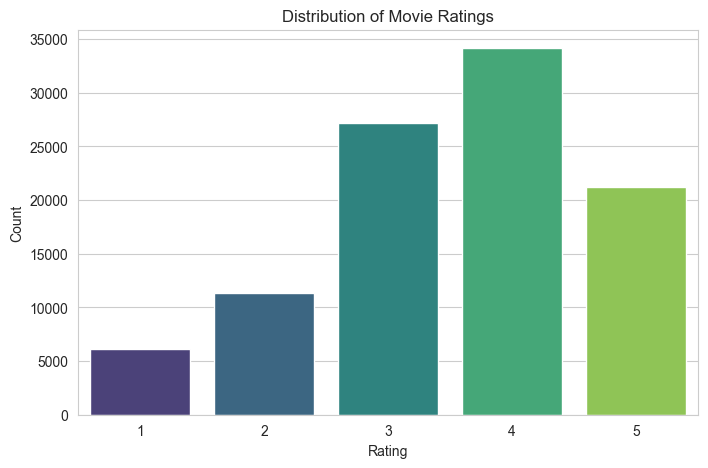


Top 10 Most Rated Movies:
title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: count, dtype: int64


/var/folders/s_/7spsm0xj60sb20xctb007jhr0000gn/T/ipykernel_65855/4052231207.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_movies.values, y=top_10_movies.index, palette='magma')


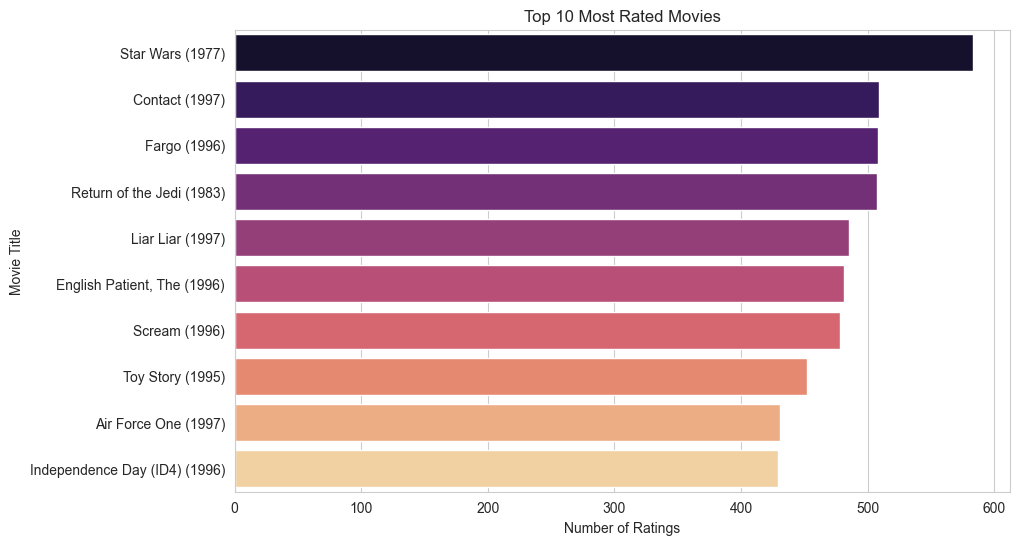


Top 10 Movies by Average Rating (excluding low rated ones later):
title
They Made Me a Criminal (1939)                       5.0
Marlene Dietrich: Shadow and Light (1996)            5.0
Saint of Fort Washington, The (1993)                 5.0
Someone Else's America (1995)                        5.0
Star Kid (1997)                                      5.0
Great Day in Harlem, A (1994)                        5.0
Aiqing wansui (1994)                                 5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Name: rating, dtype: float64

Movie Stats (first 5 rows - sorted by num_ratings):
                           average_rating  num_ratings
title                                                 
Star Wars (1977)                 4.358491          583
Contact (1997)                   3.803536          509
Fargo (1996)                     4.155512          508


/var/folders/s_/7spsm0xj60sb20xctb007jhr0000gn/T/ipykernel_65855/4052231207.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='cubehelix')


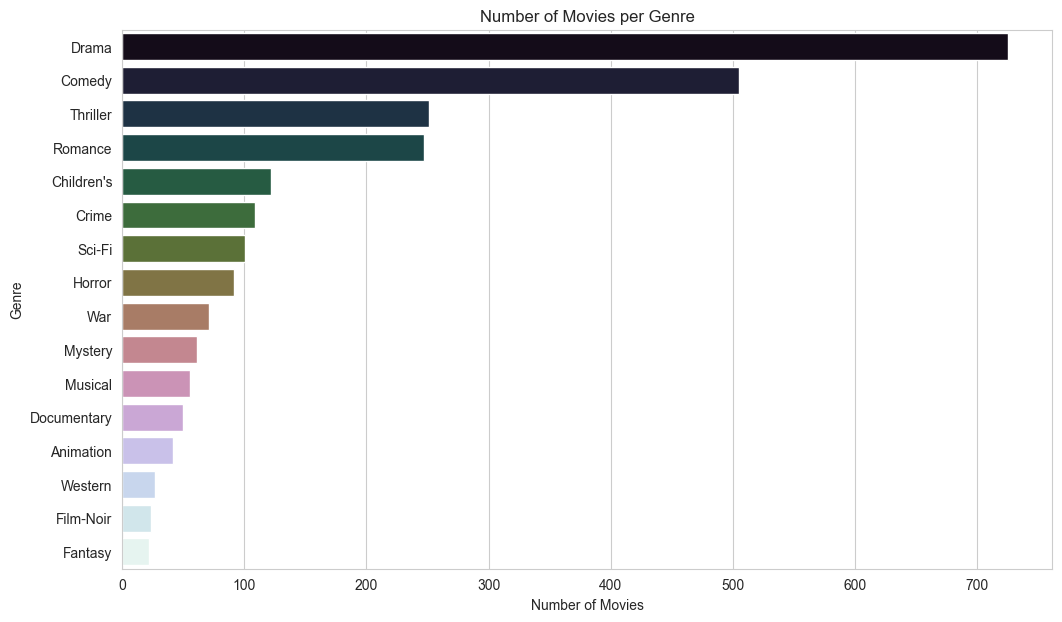

In [3]:
# Number of unique users and movies
print(f"\nNumber of unique users: {df['user_id'].nunique()}")
print(f"Number of unique movies: {df['movie_id'].nunique()}")
print(f"Total ratings: {len(df)}")

# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Top 10 most rated movies
top_10_movies = df['title'].value_counts().head(10)
print("\nTop 10 Most Rated Movies:")
print(top_10_movies)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_movies.values, y=top_10_movies.index, palette='magma')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

# Average rating per movie
avg_ratings = df.groupby('title')['rating'].mean().sort_values(ascending=False)
print("\nTop 10 Movies by Average Rating (excluding low rated ones later):")
print(avg_ratings.head(10))

# Combine with number of ratings to avoid highly rated but rarely watched movies
ratings_count = df.groupby('title')['rating'].count()
movie_stats = pd.DataFrame({'average_rating': avg_ratings, 'num_ratings': ratings_count})
movie_stats = movie_stats.sort_values(by='num_ratings', ascending=False)
print("\nMovie Stats (first 5 rows - sorted by num_ratings):")
print(movie_stats.head())

# Filter out movies with less than a certain number of ratings (ex, 50)
min_ratings_threshold = 50
popular_movies_stats = movie_stats[movie_stats['num_ratings'] >= min_ratings_threshold].sort_values(by='average_rating', ascending=False)
print(f"\nTop 10 Movies by Average Rating (min {min_ratings_threshold} ratings):")
print(popular_movies_stats.head(10))

# Genre distribution
genre_counts = movies_df.iloc[:, 5:].sum().sort_values(ascending=False)
print("\nGenre Distribution:")
print(genre_counts)

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='cubehelix')
plt.title('Number of Movies per Genre')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

In [4]:
# Create a content string for each movie (genres and title are good starting points)
# We'll use the binary genre columns as features
# For simplicity, we'll convert the genre columns to a space-separated string of genres
def get_genres_string(row):
    genres = [col for col in movies_df.columns[5:] if row[col] == 1]
    return ' '.join(genres)

movies_df['genres_str'] = movies_df.apply(get_genres_string, axis=1)

# Combine title and genres for content description
# Basic cleaning for title (removing year in parentheses, if present)
movies_df['clean_title'] = movies_df['title'].apply(lambda x: re.sub(r' \(\d{4}\)', '', x).strip())
movies_df['content_description'] = movies_df['clean_title'] + ' ' + movies_df['genres_str']

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the content descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['content_description'])

# Calculate Cosine Similarity
# This creates a similarity matrix where each entry [i, j] is the similarity between movie i and movie j
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a mapping from movie title to movie index
title_to_index = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

def get_content_based_recommendations(movie_title, cosine_sim_matrix, df_movies, top_n=10):
    """
    Generates content-based recommendations for a given movie title.
    """
    if movie_title not in df_movies['title'].values:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return []

    idx = title_to_index[movie_title] # Get the index of the movie
    sim_scores = list(enumerate(cosine_sim_matrix[idx])) # Get similarity scores with all other movies
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # Sort movies by similarity score
    sim_scores = sim_scores[1:top_n+1] # Exclude the movie itself (first element) and get top N
    movie_indices = [i[0] for i in sim_scores] # Get the movie indices
    return df_movies['title'].iloc[movie_indices].tolist()

# Test the content-based recommender
print("\nContent-Based Recommendations for 'Star Wars (1977)':")
print(get_content_based_recommendations('Star Wars (1977)', cosine_sim, movies_df))

print("\nContent-Based Recommendations for 'Toy Story (1995)':")
print(get_content_based_recommendations('Toy Story (1995)', cosine_sim, movies_df))


Content-Based Recommendations for 'Star Wars (1977)':
['Star Kid (1997)', 'Star Trek: First Contact (1996)', 'Star Trek: Generations (1994)', 'Aliens (1986)', 'Star Trek V: The Final Frontier (1989)', 'Star Trek: The Motion Picture (1979)', 'Return of the Jedi (1983)', 'In Love and War (1996)', 'Star Trek: The Wrath of Khan (1982)', 'Empire Strikes Back, The (1980)']

Content-Based Recommendations for 'Toy Story (1995)':
['Philadelphia Story, The (1940)', 'Story of Xinghua, The (1993)', 'NeverEnding Story III, The (1994)', 'FairyTale: A True Story (1997)', "Pyromaniac's Love Story, A (1995)", 'Aladdin (1992)', 'Pinocchio (1940)', 'Hercules (1997)', 'Aristocats, The (1970)', 'Balto (1995)']


In [5]:
# phase 4
# Prepare data for Surprise library
reader = Reader(rating_scale=(1, 5)) # Ratings are from 1 to 5
data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Choose a collaborative filtering algorithm: SVD (Singular Value Decomposition)
# SVD is a popular matrix factorization technique.
svd_model = SVD(random_state=42)

# Train the model
svd_model.fit(trainset)

# Make predictions on the test set
predictions = svd_model.test(testset)

# Evaluate the model
print("\nCollaborative Filtering (SVD) Model Evaluation:")
accuracy.rmse(predictions, verbose=True) # Root Mean Squared Error
accuracy.mae(predictions, verbose=True)  # Mean Absolute Error

# Cross-validation for more robust evaluation (optional but good practice)
print("\nCollaborative Filtering (SVD) Cross-Validation (RMSE & MAE):")
cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


# Function to get collaborative filtering recommendations for a user
def get_collaborative_recommendations(user_id, model, df_ratings, df_movies, top_n=10):
    """
    Generates collaborative filtering recommendations for a given user_id.
    """
    # Get a list of all movie IDs
    all_movie_ids = df_movies['movie_id'].unique()

    # Get movies the user has already rated
    rated_movie_ids = df_ratings[df_ratings['user_id'] == user_id]['movie_id'].unique()

    # Get movies the user has NOT rated
    unrated_movie_ids = [mid for mid in all_movie_ids if mid not in rated_movie_ids]

    # Predict ratings for unrated movies
    predictions = []
    for movie_id in unrated_movie_ids:
        # The 'predict' method returns a prediction object, we need the estimated rating
        pred = model.predict(uid=user_id, iid=movie_id).est
        predictions.append((movie_id, pred))

    # Sort predictions by estimated rating in descending order
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations
    top_recommendations = predictions[:top_n]

    # Get movie titles for the recommended movie IDs
    recommended_movie_titles = [df_movies[df_movies['movie_id'] == mid]['title'].iloc[0] for mid, _ in top_recommendations]

    return recommended_movie_titles

# Test the collaborative filtering recommender for a specific user (e.g., user_id 1)
user_to_test = 1
print(f"\nCollaborative Filtering Recommendations for User {user_to_test}:")
print(get_collaborative_recommendations(user_to_test, svd_model, ratings_df, movies_df))

# Test for another user (e.g., user_id 100)
user_to_test_2 = 100
print(f"\nCollaborative Filtering Recommendations for User {user_to_test_2}:")
print(get_collaborative_recommendations(user_to_test_2, svd_model, ratings_df, movies_df))


Collaborative Filtering (SVD) Model Evaluation:
RMSE: 0.9396
MAE:  0.7408

Collaborative Filtering (SVD) Cross-Validation (RMSE & MAE):
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9287  0.9323  0.9371  0.9417  0.9381  0.9356  0.0046  
MAE (testset)     0.7322  0.7361  0.7379  0.7431  0.7373  0.7373  0.0035  
Fit time          0.38    0.39    0.39    0.41    0.40    0.39    0.01    
Test time         0.04    0.03    0.04    0.08    0.04    0.04    0.02    

Collaborative Filtering Recommendations for User 1:
['Close Shave, A (1995)', 'Manchurian Candidate, The (1962)', 'Casablanca (1942)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)', 'Secrets & Lies (1996)', 'Lawrence of Arabia (1962)', "Schindler's List (1993)", 'Third Man, The (1949)', 'Man Who Would Be King, The (1975)', 'Wings of Desire (1987)']

Collaborative Filtering Recommendations for User 

In [ ]:
# phase 6
# use main app.py to run 